## Model for dynamic currency hedging
Hedging costs (interest rate differential) are at an All-time low now for Swiss investors. So it's much cheaper to hedge now. Should the hedge-ratio therefore increase?

Do an empirical analysis and find out whether hedging costs are a good indicator for future currency returns. My thesis: When hedging costs are low, future FX returns are actually positive (because of mean-reversion) and therefore increasing hedging when costs are low is not optimal.

Do valuations of currencies play a role in hedging? Do an empirical analysis and find out whether hedging expensive currencies and not hedging cheap currencies was a good strategy.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

#### Hedging cost as indicator for future currency returns

In [2]:
# Need FX and interest rates
currencies = "Data/FX_CHF_ALL_1971-2020.xlsx"
interest_rates = "Data/3M_interest_rates.xlsx"

# FX
df_fx_indirect = pd.read_excel(currencies, header=0, index_col=0, sheet_name="Sheet1")
df_fx_direct = 1 / df_fx_indirect
df_fx_direct = df_fx_direct.replace([np.inf, -np.inf], np.nan)
df_fx_direct.columns = ['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']

# Interest rates
df_r = pd.read_excel(interest_rates, header=1, index_col=0)
df_r.columns = ['CHF', 'USD', 'EUR', 'GBP', 'JPY', 'CAD', 'AUD']
df_r = df_r/100
df_r = df_r[df_r!=0].dropna()

# Do analysis based on monthly data

# FX
df_fx_direct_m = df_fx_direct.resample('M').last()
df_fx_direct_m = df_fx_direct_m[df_fx_direct_m!=0].dropna()

# Interest rates
df_r_m = df_r.resample('M').last()
df_r_m = df_r_m[df_r_m!=0].dropna()

# Only keep data of common dates
index_intersection = df_r_m.index.intersection(df_fx_direct_m.index)
df_fx_direct_m = df_fx_direct_m.loc[index_intersection]
df_r_m = df_r_m.loc[index_intersection]


Text(0.5, 1.0, 'Interest rate differentials (foreign rate minus CHF rate)')

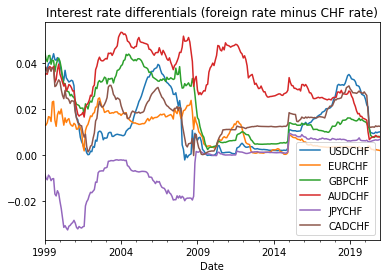

In [3]:
# Get interest rate differentials for currency pairs. Base currency is CHF, so foreign interest rate minus CHF rate
df_r_diff = pd.DataFrame(columns = df_fx_direct_m.columns, index = df_fx_direct_m.index)
df_r_diff['USDCHF'] = df_r_m['USD'] - df_r_m['CHF']
df_r_diff['EURCHF'] = df_r_m['EUR'] - df_r_m['CHF']
df_r_diff['GBPCHF'] = df_r_m['GBP'] - df_r_m['CHF']
df_r_diff['AUDCHF'] = df_r_m['AUD'] - df_r_m['CHF']
df_r_diff['JPYCHF'] = df_r_m['JPY'] - df_r_m['CHF']
df_r_diff['CADCHF'] = df_r_m['CAD'] - df_r_m['CHF']

df_r_diff.plot()
plt.title('Interest rate differentials (foreign rate minus CHF rate)')



1 month ahead fx returns


Intercept   -0.025896
x            1.434214
dtype: float64
RSquared: 0.004


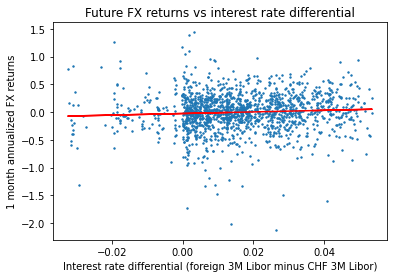



2 month ahead fx returns


Intercept   -0.026014
x            1.434676
dtype: float64
RSquared: 0.01


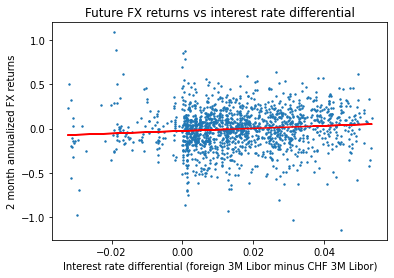



3 month ahead fx returns


Intercept   -0.025845
x            1.386582
dtype: float64
RSquared: 0.014


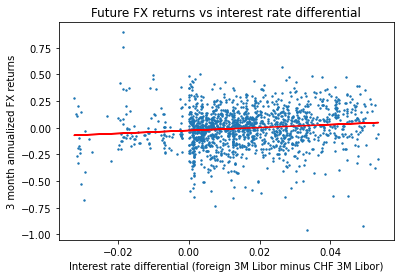



6 month ahead fx returns


Intercept   -0.027003
x            1.367418
dtype: float64
RSquared: 0.029


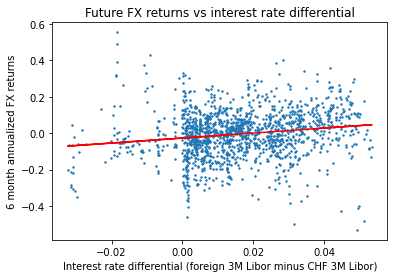



12 month ahead fx returns


Intercept   -0.029621
x            1.441740
dtype: float64
RSquared: 0.068


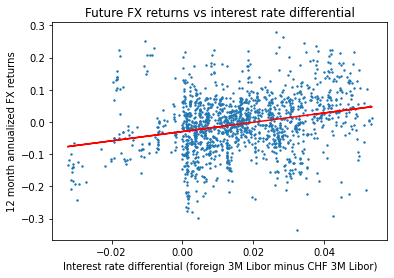



18 month ahead fx returns


Intercept   -0.029773
x            1.387665
dtype: float64
RSquared: 0.108


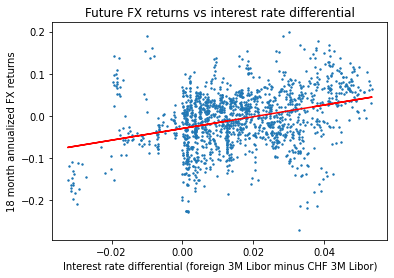



24 month ahead fx returns


Intercept   -0.027854
x            1.244484
dtype: float64
RSquared: 0.125


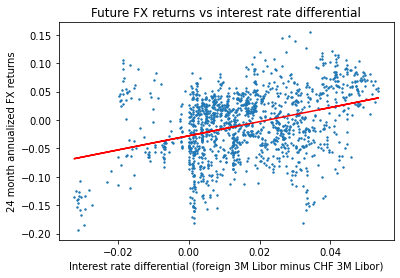



36 month ahead fx returns


Intercept   -0.024565
x            1.029553
dtype: float64
RSquared: 0.137


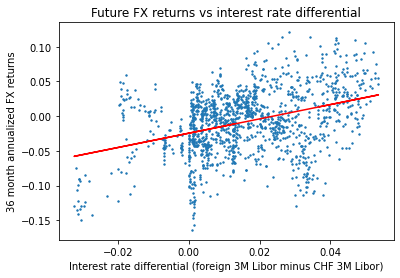

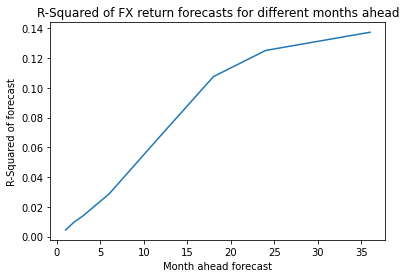

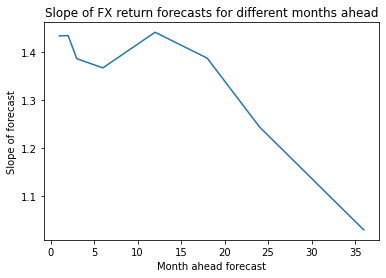

,1,2,3,6,12,18,24,36
slope,1.434214,1.434676,1.386582,1.367418,1.441740,1.387665,1.244484,1.029553
RSquared,0.004437,0.009856,0.013919,0.028691,0.068371,0.107640,0.125222,0.137465


In [8]:
# Get future currency returns

# Function to get forward rates
def fx_forward(currency_pair, t, t_1, fx, interest_rates):
    """Useage:
    date_1 = pd.Timestamp('2020-12-16')
    date_2 = pd.Timestamp('2020-12-18')
    fx_forward('USDCHF', date_1, date_2, df_fx, df_r)
    """
    # Get spot exchange rate and LIBOR rates
    s = fx.loc[t, currency_pair]
    r_d = interest_rates.loc[t, currency_pair[3:]]
    r_f = interest_rates.loc[t, currency_pair[:3]]
    
    # Calculate number of days
    n_days = t_1 - t
    n_days = n_days.days
    
    # Forward rate
    f = np.log(s) + np.log(1+r_d)*n_days/365 - np.log(1+r_f)*n_days/365
    
    return np.exp(f)


# N month ahead exchange rate forecasting
forecast_durations = [1,2,3,6,12,18,24,36]

# To store result
fx_forecast = pd.DataFrame(columns=['slope', 'RSquared'], index=forecast_durations)

# Create forecasts for every duration
for n in forecast_durations:

    # Create a df with monthly forward rates
    df_f_m = pd.DataFrame(index=df_r_diff.index, columns=df_r_diff.columns)
    df_f_m = df_f_m.sort_index()
    for d in range(len(df_f_m.index)-n):
        for c in range(len(df_f_m.columns)):
            try:
                df_f_m.iloc[d, c] = fx_forward(df_f_m.columns[c], df_f_m.index[d], df_f_m.index[d+n], df_fx_direct_m, df_r_m)
            except KeyError:
                print(d)
                df_f_m.iloc[d, c] = np.nan

    # Future FX returns are log(future spot rate) - log(forward rate)
    # Somehow np.log(df_f_m) gives an error
    df_f_m_log = df_f_m.copy()
    for c in df_f_m_log.columns:
        for i in df_f_m_log.index:
            df_f_m_log.loc[i,c] = np.log(df_f_m.loc[i,c])
    df_future_fx_ret = np.log(df_fx_direct_m.shift(-n)) - df_f_m_log
    
    # Annualize the returns
    df_future_fx_ret = 12 * df_future_fx_ret / n

    # First individual currencies
    # for c in df_future_fx_ret.columns:

        # x = df_r_diff[c]
        # y = df_future_fx_ret[c]
        # df = pd.DataFrame({'x':pd.to_numeric(x), 'y':pd.to_numeric(y)})
        # df = df[df!=0].dropna()
        # mod = ols('y ~ x', data=df).fit()
        # if mod.rsquared > 0.05:
            # print(n)
            # print(c)
            # plt.scatter(df_r_diff[c], df_future_fx_ret[c])
            # plt.show()
            # print(mod.params)
            # print(mod.rsquared)
    
    # Now all currencies
    x = df_r_diff.unstack()
    y = df_future_fx_ret.unstack()
    df = pd.DataFrame({'x':pd.to_numeric(x), 'y':pd.to_numeric(y)})
    df = df[df!=0].dropna()
    mod = ols('y ~ x', data=df).fit()
    
    # Print some info
    print('\n')
    print(str(n) + ' month ahead fx returns')
    print('\n')
    print(mod.params)
    print('RSquared: ' + str(round(mod.rsquared,3 )))
    
    # Store info in df
    fx_forecast.loc[n, 'slope'] = mod.params['x']
    fx_forecast.loc[n, 'RSquared'] = mod.rsquared
    
    # Scatter plot
    plt.scatter(x, y, s=2)
    plt.plot(x.values ,mod.params['Intercept'] + mod.params['x']*x.values,"r")
    plt.title('Future FX returns vs interest rate differential')
    plt.xlabel('Interest rate differential (foreign 3M Libor minus CHF 3M Libor)')
    plt.ylabel(str(n) + ' month annualized FX returns')
    plt.show()

# Plot to visualize RSquared
fx_forecast['RSquared'].plot()
plt.title('R-Squared of FX return forecasts for different months ahead')
plt.xlabel('Month ahead forecast')
plt.ylabel('R-Squared of forecast')
plt.show()

# Plot to visualize slope of regressions
fx_forecast['slope'].plot()
plt.title('Slope of FX return forecasts for different months ahead')
plt.xlabel('Month ahead forecast')
plt.ylabel('Slope of forecast')
plt.show()

# Summary of forecasts
fx_forecast.transpose()

#### Outcome
When hedging, meaning to go short the foreign currency, you take a loan in the foreign currency and invest it in CHF. Therefore the differential, or the hedging cost are foreign interest rate minus CHF interest rate. From the scatter plot we can see that if the differential is high, a long position in the fx will create positive returns. However, when hedging you take a short position in the foreign currency, meaning that if the differential is high the short position will have negative returns. 

Therefore you should not hedge when the differential is high, but you should hedge when the differential is low and hedging cost are low.